In [199]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [200]:
# convert MNIST image files into a tensor of 4dim (num_of_images, height, width, color chan)
transform = transforms.ToTensor()

In [201]:
# train data
train_data = datasets.MNIST(root='./cnn_data', train=True, download=True, transform=transform)

In [202]:
# test_data
test_data = datasets.MNIST(root='./cnn_data', train=False, download=True, transform=transform)

In [203]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [204]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [205]:
# create a small batch size for images
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [206]:
# define cnn model
# describe convolutional layer (2 layers)
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

In [207]:
# grab one 1 MINST image
for i, (X_train, y_train) in enumerate(train_data):
    break
X_train.shape

torch.Size([1, 28, 28])

In [208]:
x = X_train.view(1,1,28,28)

In [209]:
# perform first convolution
x = F.relu(conv1(x))

In [210]:
# 1st dim is 1 image, 6 is the num of filters, 26x26 is the image size and is reduced because of no padding set
x.shape

torch.Size([1, 6, 26, 26])

In [211]:
# pass through the pooling layer
x = F.max_pool2d(x, 2, 2)

In [212]:
x.shape # 26/2 = 13

torch.Size([1, 6, 13, 13])

In [213]:
# second convolutional layer
x = F.relu(conv2(x))

In [214]:
x.shape # no padding so we lost 1 pixel on each side

torch.Size([1, 16, 11, 11])

In [215]:
# second pooling layor
x = F.max_pool2d(x,2,2)

In [216]:
x.shape # 11/2 = 5.5 but have to round down since we cant create data to round up

torch.Size([1, 16, 5, 5])

In [217]:
# building the model
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        # fully connected layers
        self.fc1 = nn.Linear(5*5*16, 120) # takes in 5*5*16 because thats the dim of our input image after CN and pooling
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) # ending with 10 because there are 10 defining classes

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        # re-view data to flatten
        X  = X.view(-1, 16*5*5) # -1 so we can vary batch size
        # fully connected layers
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)


In [218]:
# create an instance of the model
torch.manual_seed(41)
model = CNN()
model

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [219]:
# loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [222]:
import time
start_time = time.time()

# create stats vars
epoch = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epoch):
    train_corr = 0
    test_corr = 0

    # train
    for b, (X_train, y_train) in enumerate(train_loader):
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1] # add up the number of correct predictions.
        batch_corr = (predicted == y_train).sum()
        train_corr += batch_corr

        # update params
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print results
        if b%600 == 0:
            print(f'Epoch: {i} Batch: {b} Loss: {loss.item()}')
    
    train_losses.append(loss)
    train_correct.append(train_corr)

    # test
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1] # adding correct predictions
            test_corr += (predicted == y_test).sum()
        loss = criterion(y_pred, y_test)
        test_losses.append(loss)
        test_correct.append(test_corr)

stop_time = time.time()
elapsed = stop_time - start_time
print(f'Training took: {elapsed/60} minutes')

Epoch: 0 Batch: 0 Loss: 0.03617922216653824
Epoch: 0 Batch: 500 Loss: 0.11078457534313202
Epoch: 0 Batch: 1000 Loss: 1.465026434743777e-05
Epoch: 0 Batch: 1500 Loss: 1.822631384129636e-05
Epoch: 0 Batch: 2000 Loss: 0.002268559066578746
Epoch: 0 Batch: 2500 Loss: 0.00011110529158031568
Epoch: 0 Batch: 3000 Loss: 0.0023553897626698017
Epoch: 0 Batch: 3500 Loss: 0.0005620616138912737
Epoch: 0 Batch: 4000 Loss: 4.678322875406593e-05
Epoch: 0 Batch: 4500 Loss: 0.005247824359685183
Epoch: 0 Batch: 5000 Loss: 0.0013394984416663647
Epoch: 0 Batch: 5500 Loss: 0.00017333938740193844
Epoch: 1 Batch: 0 Loss: 0.005963614676147699
Epoch: 1 Batch: 500 Loss: 0.012982646934688091
Epoch: 1 Batch: 1000 Loss: 9.706222772365436e-05
Epoch: 1 Batch: 1500 Loss: 0.0005637998692691326
Epoch: 1 Batch: 2000 Loss: 0.02355377934873104
Epoch: 1 Batch: 2500 Loss: 0.0005470839096233249
Epoch: 1 Batch: 3000 Loss: 1.7618027413845994e-05
Epoch: 1 Batch: 3500 Loss: 4.125108171137981e-05
Epoch: 1 Batch: 4000 Loss: 0.005500

In [224]:
# graph the loss at each epoch
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Loss at Epoch")
plt.legend()
plt.show()

AttributeError: 'float' object has no attribute 'item'

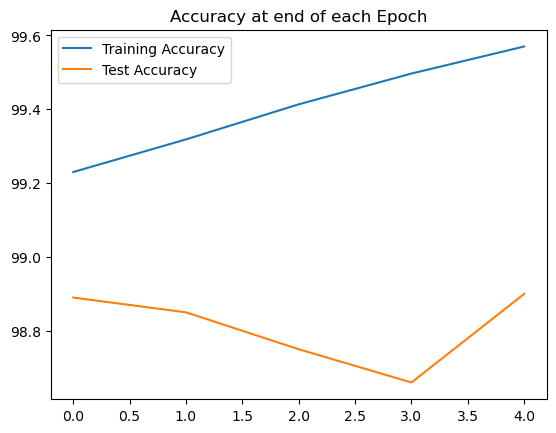

In [226]:
plt.plot([t/600 for t in train_correct], label="Training Accuracy")
plt.plot([t/100 for t in test_correct], label="Test Accuracy")
plt.title("Accuracy at end of each Epoch")
plt.legend()
plt.show()

In [227]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [228]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_everything:
        y_val = model(X_test)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()

In [232]:
correct.item() / len(test_data) * 100

98.9

In [233]:
# grab an image
test_data[4143] 

9

In [234]:
# grab the data
test_data[4143][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [235]:
# reshape
test_data[4143][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

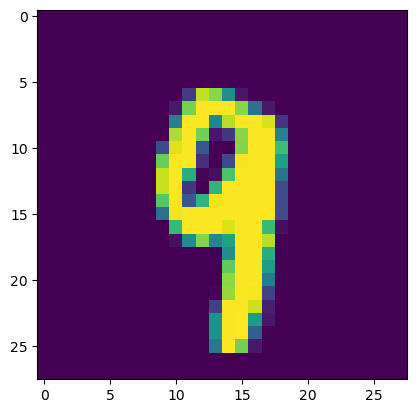

In [236]:
# show image
plt.imshow(test_data[4143][0].reshape(28,28))

In [237]:
# pass image through model
model.eval()
with torch.no_grad():
    new_prediction = model(test_data[4143][0].view(1,1,28,28))

In [238]:
# check new prediction
new_prediction

tensor([[-3.1805e+01, -2.6346e+01, -3.3854e+01, -2.7963e+01, -1.5003e+01,
         -2.8704e+01, -4.5936e+01, -1.6989e+01, -1.9665e+01, -3.5763e-07]])

In [239]:
new_prediction.argmax()

tensor(9)